In [24]:
# Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split, KFold, cross_validate
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.utils import shuffle

# Helper file
import helper_data_generator

# Models
from PEA import PerformanceEnrichmentAnalysisClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier

# Metric
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, precision_score, \
recall_score, SCORERS, roc_auc_score, roc_curve, auc, precision_recall_curve

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline




# from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelBinarizer, label_binarize
import pandas as pd
from PEA import PerformanceEnrichmentAnalysisClassifier
import math
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, cohen_kappa_score, matthews_corrcoef, log_loss
import numpy as np
import matplotlib.pyplot as plt
# from timeit import Timer




In [77]:
# Choose any list of classifiers

classifier_list = [
     PerformanceEnrichmentAnalysisClassifier(
        number_of_clusters=20, permutations=100),
     KNeighborsClassifier(3),
     DummyClassifier(strategy='uniform'),
     DummyClassifier(strategy='most_frequent'),
     # SVC(kernel="linear", C=0.025),
     #SVC(gamma=2, C=1),
     DecisionTreeClassifier(max_depth=5),
     # RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
     # MLPClassifier(alpha=0.01),
     # AdaBoostClassifier(),
     #GaussianNB(),
     # QuadraticDiscriminantAnalysis()
]

In [ ]:
def get_syn_data_from_make_blob(number_of_samples,
                                number_of_features,
                                number_of_clusters,
                                cluster_std_dev):
    '''
    Calls sklearn.make_blobs and get_indexed_df()

    Returns synthetic dataframe and columns
    '''

    X, y = make_blobs(n_samples=number_of_samples,
                      n_features=number_of_features,
                      centers=number_of_clusters,
                      cluster_std=cluster_std_dev)

    syn_df, cols = get_indexed_df(X, y, number_of_features)

    return syn_df, cols



In [76]:
def get_syn_data_from_make_classification(number_of_samples,
                                          number_of_features,
                                          number_informative_features,
                                          number_redundant_features,
                                          number_repeated_features,
                                          number_classes,
                                          number_clusters_per_class,
                                          class_separator,
                                          flip_y,
                                          weights):
    '''
    Calls sklearn.make_classification and get_indexed_df()

    Returns synthetic dataframe and columns
    '''

    X, y = make_classification(n_samples=number_of_samples,
                               n_features=number_of_features,
                               n_informative=number_informative_features,
                               n_redundant=number_redundant_features,
                               n_repeated=number_repeated_features,
                               n_classes=number_classes,
                               n_clusters_per_class=number_clusters_per_class,
                               class_sep=class_separator,
                               flip_y=flip_y,
                               weights=weights)

    syn_df, cols = get_indexed_df(X, y, number_of_features)

    return syn_df, cols




In [ ]:

def get_make_blob_data(number_of_samples,
                       number_of_features,
                       number_of_clusters,
                       cluster_std_dev):
    '''
    Calls get_syn_data_from_make_blob() to fetch synthetic dataframe & columns

    Returns train and test splitted data
    '''

    target_attribute = 'label'

    syn_df, cols = get_syn_data_from_make_blob(number_of_samples,
                                               number_of_features,
                                               number_of_clusters,
                                               cluster_std_dev)

    X_full = syn_df.loc[:, cols].reset_index(drop=True)
    y_full = syn_df.loc[:, target_attribute].reset_index(drop=True)

    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y_full, test_size=0.1)

    return (X_train, X_test, y_train, y_test)



In [ ]:


def get_make_classification_data(
                                number_of_samples,
                                number_of_features,
                                number_informative_features,
                                number_redundant_features,
                                number_repeated_features,
                                number_classes,
                                number_clusters_per_class,
                                class_separator,
                                flip_y,
                                weights):
    '''
    Calls get_syn_data_from_make_classification() to fetch synthetic dataframe
    & columns

    Returns train and test splitted data
    '''

    target_attribute = 'label'

    syn_df, cols = get_syn_data_from_make_classification(
                                                number_of_samples,
                                                number_of_features,
                                                number_informative_features,
                                                number_redundant_features,
                                                number_repeated_features,
                                                number_classes,
                                                number_clusters_per_class,
                                                class_separator,
                                                flip_y,
                                                weights)

    X_full = syn_df.loc[:, cols].reset_index(drop=True)
    y_full = syn_df.loc[:, target_attribute].reset_index(drop=True)

    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y_full, test_size=0.1)

    return (X_train, X_test, y_train, y_test)




In [ ]:

def get_indexed_df(X, y, number_of_features):
    '''
    Create dynamic column names with same number_of_features
    Create Indexed dataframe for label
    Create Indexed dataframe for features

    Returns synthetic dataframe and column names
    '''

    column_size = X.shape[1]
    cols = [x + str(i) for x, i in zip(["col"]*column_size,
                                       range(column_size))]

    y = pd.DataFrame(y, columns=['label'])
    y.index = np.arange(0, len(y))
    y.index.name = 'index'

    syn_df = pd.DataFrame(X, columns=cols)
    syn_df.index = np.arange(0, len(syn_df))
    syn_df.index.name = 'index'
    syn_df = syn_df.merge(y, on='index')

    return syn_df, cols




In [ ]:

def get_scaled_data(x_train, x_test):
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    return x_train, x_test




In [ ]:

def train_test_classifier_print_results(clf,
                                        list_accuracies,
                                        metric,
                                        X_train,
                                        X_test,
                                        y_train,
                                        y_test):
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    if metric=='accuracy':
        correct_rate = accuracy_score(y_test, prediction)
    elif metric=='f1_score':
        # labels = np.unique(prediction) as we want the prediction for all the three labels [0,1,2]
        correct_rate = f1_score(y_test, prediction, average='weighted', labels=np.unique(prediction))
    elif metric=='precision':
        correct_rate = precision_score(y_test, prediction, average='weighted', labels=np.unique(prediction))
    elif metric=='recall':
        correct_rate = recall_score(y_test, prediction, average='weighted', labels=np.unique(prediction))
    elif metric=='cohen_kappa_score':
        correct_rate = cohen_kappa_score(y_test, prediction) 
    elif metric=='matthews_corrcoef':
        correct_rate = matthews_corrcoef(y_test, prediction) 
    elif metric=='roc_auc':
#         lb = LabelBinarizer()
#         lb.fit(y_test)
#         y_test = lb.transform(y_test)
#         prediction = lb.transform(prediction)
        y_test = label_binarize(y_test, classes=[0,1,2])
        prediction = label_binarize(prediction, classes=[0,1,2])
        correct_rate = roc_auc_score(y_test, prediction, average='samples')
        
    list_accuracies.append(correct_rate)
    return list_accuracies
    #return correct_rate



In [ ]:

def encode_target_features_to_categorical(target_feature_values, borders):
    """Assign the corresponding integer-valued code to the observable falling
    into the bins defined by borders.

    Args:
        target_feature_values: pandas Series
        borders: borders of intervals the observable must be
            divided in, list of numbers

    Returns:
        observable_encoded: pandas Series
        observable_label: list of symmetric integer-valued codes
            (e.g. [-2, -1, 1, 2])
    """

    n_int = len(borders) + 1
    encoded_label_names = [x for x in range(math.ceil(-n_int/2),
                                            math.floor(n_int/2) + 1)]
    if (n_int % 2 == 0):
        encoded_label_names.remove(0)

    bins = sorted(borders + [-math.inf, +math.inf])
    encoded_values = pd.cut(target_feature_values,
                            bins=bins,
                            labels=encoded_label_names)
    return encoded_values, encoded_label_names



In [ ]:


def get_list_accuracies_pea_data(num_of_iterations, X, y, classifier_list):

    pea_list_accuracies = []
    for i in range(num_of_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)
        X_train, X_test = get_scaled_data(X_train, X_test)
        train_test_classifier_print_results(classifier_list[0],
                                            pea_list_accuracies,
                                            X_train,
                                            X_test,
                                            y_train,
                                            y_test)

    for clf in classifier_list[1:]:
        ml_list_accuracies = []
        for i in range(num_of_iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                                test_size=0.1)
            X_train, X_test = get_scaled_data(X_train, X_test)
            train_test_classifier_print_results(clf,
                                                ml_list_accuracies,
                                                X_train,
                                                X_test,
                                                y_train,
                                                y_test)

    return pea_list_accuracies, ml_list_accuracies




In [ ]:

def get_list_accuracies_blob_data(num_of_iterations,
                                  classifier_list,
                                  number_of_samples,
                                  number_of_features,
                                  number_of_clusters,
                                  cluster_std_dev):

    pea_list_accuracies = []

    for i in range(num_of_iterations):
        X_train, X_test, y_train, y_test = get_make_blob_data(
                                                      number_of_samples,
                                                      number_of_features,
                                                      number_of_clusters,
                                                      cluster_std_dev)

        X_train, X_test = get_scaled_data(X_train, X_test)
        train_test_classifier_print_results(classifier_list[0],
                                            pea_list_accuracies,
                                            X_train,
                                            X_test,
                                            y_train,
                                            y_test)

    for clf in classifier_list[1:]:
        ml_list_accuracies = []
        for i in range(num_of_iterations):
            X_train, X_test, y_train, y_test = get_make_blob_data(
                                                      number_of_samples,
                                                      number_of_features,
                                                      number_of_clusters,
                                                      cluster_std_dev)
            X_train, X_test = get_scaled_data(X_train, X_test)
            train_test_classifier_print_results(clf,
                                                ml_list_accuracies,
                                                X_train,
                                                X_test,
                                                y_train,
                                                y_test)

    return pea_list_accuracies, ml_list_accuracies




In [ ]:
def make_classifier_data_accuracies(classifier_list, metric, class_sep=None, noise=None, cluster_per_class=None):
    
    default_class_separator = 0
    default_noise = 0
    def_cluster_per_class = 1
    
    if class_sep is None:
        class_separator = default_class_separator
    else:
        class_separator = class_sep

    if noise is None:
        flip_y = default_noise
    else:
        flip_y = noise
        
    if cluster_per_class is None:
        number_clusters_per_class = def_cluster_per_class
    else:
        number_clusters_per_class = cluster_per_class
    
    # Default Feature arguments
    number_of_samples = 1000
    number_of_features = 27
    number_informative_features = 6
    number_redundant_features = 21
    number_repeated_features = 0
    number_classes = 3

    # according to the PEA dataset
    weights = [0.6501412792191112, 0.002440277421012073, 0.3474184433598767]
    # -1, 0, 1 in PEA data ~~> 0, 1, 2 in make_classification data

    X_train, X_test, y_train, y_test = get_make_classification_data(
                                                number_of_samples,
                                                number_of_features,
                                                number_informative_features,
                                                number_redundant_features,
                                                number_repeated_features,
                                                number_classes,
                                                number_clusters_per_class,
                                                class_separator,
                                                flip_y,
                                                weights)

    X_train, X_test = get_scaled_data(X_train, X_test)

    list_lists_clf_accuracies = []
    list_lists_clf = []
    
    # Create a list of lists of accuracies
    for i in range(len(classifier_list)):
        list_lists_clf.append('list'+str(i))
    
    # Instantiate each list
    for i in range(len(list_lists_clf)):
        list_lists_clf[i] = []
    
    for i in range(len(classifier_list)):
        if isinstance(classifier_list[i],PerformanceEnrichmentAnalysisClassifier):
            name = 'PEA'
            list_lists_clf_accuracies.append((name,train_test_classifier_print_results(classifier_list[i], list_lists_clf[i],                 metric, X_train, X_test, y_train, y_test)))
        else:
            list_lists_clf_accuracies.append((str(classifier_list[i]).split('(')[0],                                        train_test_classifier_print_results(classifier_list[i], list_lists_clf[i], metric, X_train, X_test, y_train, y_test)))
        
    return list_lists_clf_accuracies




In [ ]:

def plot(range_param, param, dict_items, type_param, size):
    
    plt.figure(figsize=size)
    
    for key, value in dict_items.items():
        if key=='PEA':
            plt.plot(range_param,value,'b--',label= str(key)+', Std Dev: '+str(np.round(np.std(value),2)))
        else:
            plt.plot(range_param,value,label= str(key)+', Std Dev: '+str(np.round(np.std(value),2)), alpha = 0.6)
    
    
    plt.xticks(ticks=[i for i in range_param[::2]]);
    plt.title( str(type_param)+ ' vs '+str(param))
    plt.xlabel(str(type_param) + '--->increasing')
    plt.ylabel(str(param))
    plt.legend(loc='best')



In [ ]:


def plot_accuracies(clf_list, metric_classifier,start, end, step, type_param, size):
    
    list_values = list(np.round(np.arange(start, end, step),2))
    
    if type_param=='noise':
        list_accuracies = [make_classifier_data_accuracies(clf_list, 
                                                                    metric = metric_classifier,
                                                                    noise = level) 
                           for level in list_values]
    elif type_param=='class_sep':
        list_accuracies = [make_classifier_data_accuracies(clf_list, 
                                                                    metric = metric_classifier,
                                                                    class_sep = level) 
                           for level in list_values]
    elif type_param=='cluster_per_class':    
        list_accuracies = [make_classifier_data_accuracies(clf_list, 
                                                                    metric = metric_classifier,
                                                                    cluster_per_class = level) 
                           for level in list_values]
    
    #display(list_accuracies)
    # Dictionary of classifier and their accuracies
    dict_items= {}
    
#     for i in range(np.array(list_accuracies).shape[1]+1):
#         dict_items[np.unique(np.array(list_accuracies).T[0][i])[0]] = np.hstack((np.array(list_accuracies).T[1][i]))
    
    #display(np.array(list_accuracies).shape[1])
    for i in range(np.array(list_accuracies).shape[1]):
        #display(np.unique(np.array(list_accuracies).T[0][i])[0])
        dict_items[np.unique(np.array(list_accuracies).T[0][i])[0]] = np.hstack((np.array(list_accuracies).T[1][i]))


    plot(list_values, metric_classifier, dict_items,type_param,size)

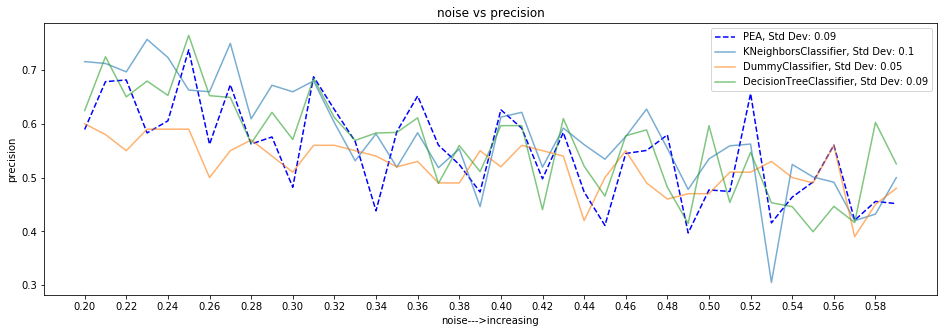

In [78]:
metric_classifier = 'precision'
start, end, step = 0.2, 0.6, 0.01
type_param = 'noise'
size = (16,5)

plot_accuracies(classifier_list, metric_classifier, start, end, step, type_param, size)